In [17]:
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt

import multiprocessing
import time
from tqdm import tqdm

from basic_ops import gen_matrix


In [18]:
def mult(A: ndarray, B: ndarray):
    n, m, t = A.shape[0], B.shape[1], A.shape[1]
    C = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            # C[i,j] = A[i,:] @ B [:, j]
            for k in range(t):
                C[i,j] += A[i,k]*B[k,j]
                C[i,j] += A[i,k]*B[k,j]
              
              
                
    return C

In [19]:
def split(A: ndarray):
    N = len(A)
    n = N//2
    return A[:n, :n], A[:n, n:], A[n:, :n], A[n:, n:]


def mult_strass(A: ndarray, B:ndarray):
    if len(A) == 2:
        return mult(A, B)

    a11, a12, a21, a22 = split(A)
    b11, b12, b21, b22 = split(B)

    p1, p2, p3, p4, p5, p6, p7 = (
        mult_strass(a11+a22, b11+b22),
        mult_strass(a21+a22, b11),
        mult_strass(a11, b12-b22),
        mult_strass(a22, b21-b11),
        mult_strass(a11+a12, b22),
        mult_strass(a21-a11, b11+b12),
        mult_strass(a12-a22, b21+b22),
    )
    
    c11, c12, c21, c22 = (
        p1 + p4 - p5 + p7,
        p3 + p5,
        p2 + p4,
        p1 + p3 - p2 + p6,
    )

    c = np.vstack((
        np.hstack((c11, c12)), 
        np.hstack((c21, c22)),
    ))
    
    return c

In [20]:
def mult_strass_parallel(A: ndarray, B: ndarray, mn: int):
    if len(A) <= 64:
        return mult(A, B)

    a11, a12, a21, a22 = split(A)
    b11, b12, b21, b22 = split(B)

    pool = multiprocessing.Pool(7)
    res = [
        pool.apply_async(mult_strass, (a11+a22, b11+b22)),
        pool.apply_async(mult_strass, (a21+a22, b11)),
        pool.apply_async(mult_strass, (a11, b12-b22)),
        pool.apply_async(mult_strass, (a22, b21-b11)),
        pool.apply_async(mult_strass, (a11+a12, b22)),
        pool.apply_async(mult_strass, (a21-a11, b11+b12)),
        pool.apply_async(mult_strass, (a12-a22, b21+b22)),
    ]
    p1, p2, p3, p4, p5, p6, p7 = map(lambda x: x.get(), res)

    c11, c12, c21, c22 = (
        p1 + p4 - p5 + p7,
        p3 + p5,
        p2 + p4,
        p1 + p3 - p2 + p6,
    )

    c = np.vstack((
        np.hstack((c11, c12)),
        np.hstack((c21, c22)),
    ))

    return c

In [21]:
def timer(func, args):
    t1 = time.time()
    res = func(*args)
    t2 = time.time()
    return res, t2-t1
    

def demo():
    base_acc, st_acc = [], []
    base_time, st_time, par_time = [], [], []

    x = list(range(3,8))

    for n in x:
        N = 2**n
        a, b = gen_matrix(N,N), gen_matrix(N,N)
        c = a@b
        
        res, tm = timer(mult, (a,b))
        base_acc.append(np.linalg.norm(c - res))
        base_time.append(tm)

        res, tm = timer(mult_strass, (a,b))
        st_acc.append(np.linalg.norm(c - res))
        st_time.append(tm)

        print(N, st_time[-1]>base_time[-1])

        _, tm = timer(mult_strass_parallel, (a,b, 2))
        par_time.append(tm)

    plt.plot(x, st_time, label='strassen time')
    plt.plot(x, par_time, label='parallel time')
    plt.plot(x, base_time, label='base time')
    plt.legend()
    plt.show()
        

    # plt.plot(x, base_acc, label='base acc')
    # plt.plot(x, st_acc, label='strassen acc')
    # plt.legend()
    # plt.show()

8 True
16 True
32 True
64 False
128 False


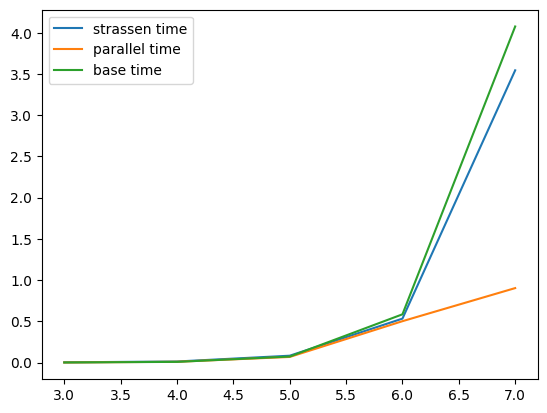

In [22]:
demo()